__Problem 1: Stratified Sampling__


The point of this problem is to illustrate stratification with non-uniform strata. We will price an Out-of-the-money Call in a Black-Scholes model (i.e. lognormal ST ). The parameters are: $S_0 = 50, r = 0.02, T = 0.5, \sigma = 0.25$. The Call strike is $K = 55$.
The stratification will be on the underlying U’s, and the strata are $A_1 = [0, 0.4]$, $A_2 = [0.4, 0.6]$, $A_3 = [0.6, 0.8]$, $A_4 = [0.8, 1]$. So the corresponding $p_i$
’s are: $p_1 = 0.4, p_2 = p_3 = p_4 = 0.2$.
We wish to use a total of M = 100 samples, split across the strata as $N_1 = 10, N_2 = N_3 = N_4 = 30$. Note that the split is not proportional to the $p_i$, but this is ok: it only matters for estimating the conditional mean $\hat{\mu}_i$ and variance $\hat{\sigma}^2_i$
in each strata.

To hand in:

1. code implementing above.

2. Estimated $\hat{\mu}_i, \hat{\sigma}_i$ for $i = 1, 2, 3, 4$
3. Overall estimated option value $\hat{V}$ (recall that it’s weighted average of $\hat{\mu}$’s)
4. Standard error $\hat{\sigma}^{str}$ of $\hat{V}$ (recall that's weighted average of $\hat{\sigma}^2$'s, plus divide by $M$)

In [1]:
import numpy as np 
from scipy.stats import binom, norm, gamma

S0 = 50; r = 0.02; T = 0.5; sigma = 0.25; K = 55; M = 100
S = np.zeros(M); V0 = np.zeros(M); Z = np.zeros(M)

U1 = np.random.uniform(0, 0.4, size = 10) 
U2 = np.random.uniform(0.4, 0.6, size = 30) 
U3 = np.random.uniform(0.6, 0.8, size = 30) 
U4 = np.random.uniform(0.8, 1, size = 30)

U = np.concatenate([U1, U2, U3, U4])

for i in range(M):
    Z[i] = norm.isf(U[i]) # inverse cdf 
    S[i] = S0*np.exp((r - sigma**2/2)*T + sigma*np.sqrt(T)*Z[i])
    V0[i] = max(S[i] - K, 0)/np.exp(r*T)

def mu(V0, N):
    return sum(V0)/N

def std(V0, N, mu):
    return np.sqrt((sum(V0 - mu)**2) / (N - 1))    

mu1 = mu(V0[0:10], 10); sigma1 = std(V0[0:10], 10, mu1)
mu2 = mu(V0[10:40], 30); sigma2 = std(V0[10:40], 30, mu2)
mu3 = mu(V0[40:70], 30); sigma3 = std(V0[40:70], 30, mu3)
mu4 = mu(V0[70:99], 30); sigma4 = std(V0[70:99], 30, mu4)

print('1.2)\n\tmu_1 = %s, sigma_1 = %s'%(mu1, sigma1))
print('\tmu_2 = %s, sigma_2 = %s'%(mu2, sigma2))
print('\tmu_3 = %s, sigma_3 = %s'%(mu3, sigma3))
print('\tmu_4 = %s, sigma_4 = %s'%(mu4, sigma4))

print('\n1.3) V_hat = %s\n'%(mu1*0.4 + 0.2*(mu2+mu3+mu4)))

stdE = sigma1*0.2 + 0.4*(sigma2+sigma3+sigma4)
print('1.4) standard error of V_hat = %s'%(stdE))

1.2)
	mu_1 = 4.9844937869486445, sigma_1 = 5.921189464667501e-16
	mu_2 = 0.0, sigma_2 = 0.0
	mu_3 = 0.0, sigma_3 = 0.0
	mu_4 = 0.0, sigma_4 = 0.0

1.3) V_hat = 1.993797514779458

1.4) standard error of V_hat = 1.1842378929335003e-16


__Problem 2: Monte Carlo for Aggregate Stop-Loss contracts__ 

In insurance context, the
insurer often uses a stop-loss contract: i.e. small losses are paid by the insured, while large losses are paid by the company. In many cases, this stop-loss operates on aggregate claims: e.g. in medical insurance there are several claims that are filed, but insurance is on the total amount to be claimed.
This is modeled by a compound distribution: $$Loss = Y_1 + Y_2 +...+Y_N = \sum_{i=1}^N Y_i$$ where $Y_i$ are i.i.d. and $N$ is the random number of claims, independent of Y ’s (covered extensively in PSTAT 173 using analytic methods).

Consider the following typical situation:

- If losses are small (less than $\$1000$, called the deductible), then the insurance company pays $\$0$;
- For total losses between $\$1000$ and $\$2500$, the insurance pays $50\%$ above the deductible (eg if Loss = 1500, insurance will pay $0.5 ∗ (1500 − 1000) = \$250$.)
- The maximum cost to the consumer is $\$2500$ - the insurer will pay 100% above this cap (eg
if Loss = 4000 then insurance will pay $\$1500$ due to the cap, plus (2500 − 1000) ∗ 0.5 = 750
using rule (b) above, for a total payment of $2250).

We assume that $N \sim Bin(n = 12, p = 0.4)$ and $Y_i$’s follow a Gamma mixture distribution with
shape=5 and rate of either 0.01 (Large claims, on average $\$500$) or shape=4, rate=0.02 (Medium
claims, on ave $\$200$). Specifically, 25% of the claims are Large, and 75% of the claims are Medium. (This is captured by an independent coin flip each time a claim is simulated).
Using above setup, and at least $M \geq 1000$ simulations (one simulation means: simulate $N$, then simulate $N \;Y$’s, compute Loss and finally Cost to insurance company):

1. Estimate probability that the insurance company doesn’t need to pay anything (ie Cost is
zero);
2. Estimate the expected cost to the insurer;
3. Estimate the probability that the insurer will have to pay out more than $1000;

Note: there is no analytical solution here; for a back-of-the-envelope calculation, $E[Loss] =
12 ∗ 0.4 ∗ (0.25 ∗ 500 + 0.75 ∗ 200) = 1320$, so roughly the company should expect to pay about $\$160$, but as you will see the spread of actual Costs is very wide and strongly affected by the deductible
and stop-loss level.

In [2]:
import random

def insurancePayout(loss):
    if loss < 1000:
        return 0 
    elif 1000 < loss < 7500:
        return 0.5*(loss - 1000)
    elif loss > 7500:
        return loss - 1750
    
# Monte Carlo simulation of Loss + Cost calculation 
M = 1000; cost = np.zeros(M); 
for i in range(M):
    
    N = np.random.binomial(12, 0.4) # number of losses
    m = sum(random.choices([0, 1], weights = (0.25, 0.75), k = N)) # medium number of claims
    
    Y = np.zeros(N)
    Y[0:m] = gamma.rvs(4, scale = 1/0.02, size = m) # medium claims
    Y[m:N] = np.random.gamma(4, scale = 1/0.01, size = N-m) # large claims 
 
    total_loss = sum(Y)
    cost[i] = insurancePayout(total_loss)
    
largeCosts = np.where(cost > 1000, 1, 0)
    
print('2.1) P(cost = 0) = %s'%(1 - np.count_nonzero(cost)/M))
print('2.2) E[cost] = %s'%(sum(cost)/M))
print('2.3) P(cost > 1000) = %s'%(sum(largeCosts)/M))

2.1) P(cost = 0) = 0.349
2.2) E[cost] = 183.99610957100342
2.3) P(cost > 1000) = 0.003


__Problem 3__ Consider two securities with $\mu_1 = 0.1, \mu_2 = 0.2$ and the covariance matrix $$\Sigma = \begin{pmatrix} 0.16 & 0.1 \\ 0.1 & 0.25 \end{pmatrix}.$$ 
1. Using R, generate a plot of the efficient frontier for this model to cover the range $\mu_V \in [0, 0.3]$. You should have at least 50 points on the frontier. Indicate which part of the frontier corresponds to portfolios without short-selling.
2. Suppose I want the portfolio that maximizes $\mu_V = 0.3\sigma_V$ . What should be my allocation? (you can use trial and error to do this)

Since $$\begin{eqnarray} \mu_V &=& 0.1w_1 + 0.2w_2 \\ &=& 0.1w_1 + 0.2(1-w_1) \\ &=& 0.2 - 0.1w_1, \end{eqnarray}$$ then $0\leq \mu_V \leq 0.3$ implies $\mu_V \in [0, 0.3] \Longleftrightarrow w_1\in [-1, 2].$

In [3]:
import matplotlib.pyplot as plt

def muX(w, mm):
    return np.dot(np.transpose(w), np.transpose(mm))

def sigmaX(w, co):
    w = np.transpose(w)
    return np.sqrt(np.dot(np.dot(w, co), np.transpose(w)))

def plotW(w, co, mm, c = None, label = None):
    plt.scatter(sigmaX(w, co), muX(w, mm), c = c, label = None)
    
mu = np.array([0.1, 0.2])
CC = np.array([[0.16, 0.1], [0.1, 0.25]])
 
plt.figure(figsize=(10, 5))
plt.title('Efficient Frontier Plot')
plt.ylabel('Mu')
plt.xlabel('Sigma')

for w1 in np.arange(-1, 2, 0.01):
    if 0 < w1 < 1:
        plotW(np.array([w1, 1-w1]), CC, mu, c = 'black')
    else:
        plotW(np.array([w1, 1-w1]), CC, mu) # short-selling

In [4]:
import pandas as pd

table = pd.DataFrame({'w1': np.arange(-1, 2, 0.01), 'w2': 1 - np.arange(-1, 2, 0.01)})
table['mu_V'] = np.array([muX(np.array([table['w1'][i], table['w2'][i]]), mu)
                          for i in range(len(table['w1']))])
table['sigma_V'] = np.array([sigmaX(np.array([table['w1'][i], table['w2'][i]]), CC)
                          for i in range(len(table['w1']))])
table['mu_V - 0.3sigma_V'] = table['mu_V'] - 0.3*table['sigma_V']

idx = table['mu_V - 0.3sigma_V'].idxmax() # index of the row that satisfies max. cond. 
w1 = round(table.iloc[idx, 0], 2)
w2 = round(table.iloc[idx, 1], 2)

print('Weights allocation should be w1 = %s and w2 = %s.'%(w1, w2))

Weights allocation should be w1 = -0.16 and w2 = 1.16.


__Problem 4__ Consider three stocks with the following rate of returns $m = [\mu_1, \mu_2, \mu_3] = [0.1 \; 0.12 \; 0.16]$ and covariance matrix $$C = \begin{pmatrix} 0.09 & -0.03 & 0 \\ -0.03 & 0.16 & 0.04 \\ 0 & 0.04 & 0.16 \end{pmatrix}.$$

1. Find the portfolio weights $w = (w_1, w_2, w_3)$ that minimize total portfolio variance.
2. Suppose you have a target return $\mu_V = 0.15$. Find the portfolio with minimal variance under this constraint. What is the associated portfolio standard deviation?
3. If the risk-free rate is $r_F = 0.04$, find the market portfolio, together with its expected return and standard deviation.

In [5]:
from numpy.linalg import det, inv 

def effPort(myMu, mm, co):
    
    uVec = np.transpose(np.array([1 for i in range(len(CC[0, :]))]))
    aa = np.array([[1.0, 1.0], [1.0, 1.0]]);  bb = np.array([[1.0, 1.0], [1.0, 1.0]])
    cc = np.array([[1.0, 1.0], [1.0, 1.0]])
    
    aa[0, 1] = (uVec.dot(inv(co))).dot(np.transpose(mm))
    aa[1, 0] = myMu
    aa[1, 1] = np.matmul(np.matmul(mm, inv(co)), np.transpose(mm))
    
    bb[0, 0] = np.matmul(np.matmul(uVec, inv(co)), np.transpose(uVec))
    bb[1, 0] = np.matmul(np.matmul(mm, inv(co)), np.transpose(uVec))
    bb[1, 1] = myMu
    
    cc[0, 0] = bb[0, 0]
    cc[0, 1] = aa[0, 1]
    cc[1, 0] = bb[1, 0]
    cc[1, 1] = aa[1, 1]

    myW = (np.dot(det(aa)*uVec, inv(co)) + np.dot(det(bb)*mm, inv(co)))/det(cc)
    
    return myW

def minVarW(uVec, CC):
    wMin = np.dot(uVec, inv(CC))
    return wMin/(np.dot(np.dot(uVec, inv(CC)), np.transpose(uVec)))
    

mu = np.array([0.1, 0.12, 0.16])
CC = np.array([[0.09, -0.03, 0], [-0.03, 0.16, 0.04], [0, 0.04, 0.16]])
uVec = np.transpose(np.array([1, 1, 1]))

wMin = minVarW(uVec, CC)
print('4.1) The portfolio weights that minimize total portfolio variance is \n\t%s.'%(wMin,))

target_w = effPort(0.15, mu, CC)/sum(effPort(0.15, mu, CC))
print('\n4.2) The portfolio weights with the target return of 0.15 is \n\t%s and its associated'
                      %(target_w,))
print('portfolio standard deviation is %s.'%sigmaX(target_w, CC))

wMarket = np.dot((mu - 0.04), inv(CC))/sum(np.dot((mu - 0.04), inv(CC)))
mu_Mk = muX(wMarket, mu); sigma_Mk = sigmaX(wMarket, CC)
print('\n4.3) The market portfolio weight is %s; its associated'%(wMarket,))
print('expected return is %s and standard deviation is %s.'%(mu_Mk, sigma_Mk))

4.1) The portfolio weights that minimize total portfolio variance is 
	[0.53179191 0.30057803 0.16763006].

4.2) The portfolio weights with the target return of 0.15 is 
	[0.09134615 0.11298077 0.79567308] and its associated
portfolio standard deviation is 0.33265756821739.

4.3) The market portfolio weight is [0.42553191 0.25531915 0.31914894]; its associated
expected return is 0.12425531914893614 and standard deviation is 0.20742225713964152.


__Problem 5__ Consider three stocks with the following rate of returns $m = [\mu_1, \mu_2, \mu_3] = [0.06, \; 0.08, \; 0.12]$ and covariance matrix $$C = \begin{pmatrix} 0.04 & 0.01 & -0.01 \\ 0.01 & 0.09 & 0 \\ -0.01 & 0 & 0.25 \end{pmatrix}.$$

a) Plot the efficient frontier for portfolios using all 3 assets in the range $\sigma_X \in [0, 0.6]$. What is the minimal portfolio variance possible?

b) Now draw (on the same plot) the efficient frontier for portfolios consisting only of Asset 1 and Asset 2. Repeat for portfolios of Asset 2+3 and Asset 1+3. In each case identify the minimal variance portfolio $M_{12}, M_{13}, M_{23}$ (namely its weights and its $(\sigma, \mu)$ coordinates).

c) Discuss how the 4 curves and the 4 min-variance portfolios look like relative to each other and why.

5a) The portfolio weights that minimize total portfolio variance is 
	[0.64307692 0.22461538 0.13230769].

5b)
	The min-Var portfolio weights with Assets 1&2 is 
	[0.72727273 0.27272727] and its expected
	return is 0.06545454545454546 and standard deviation is 0.17837651700316895.

	The min-Var portfolio weights with Assets 1&3 is 
	[0.83870968 0.16129032] and its expected
	return is 0.0696774193548387 and standard deviation is 0.17870501915438117.

	The min-Var portfolio weights with Assets 2&3 is 
	[0.73529412 0.26470588] and its expected
	return is 0.09058823529411764 and standard deviation is 0.25724787771376323.

5c) Legend: 
 	efficient:black 
 	inefficient:blue 
 	asset1&2:pink 
 	asset1&3:green 
 	asset2&3:magenta


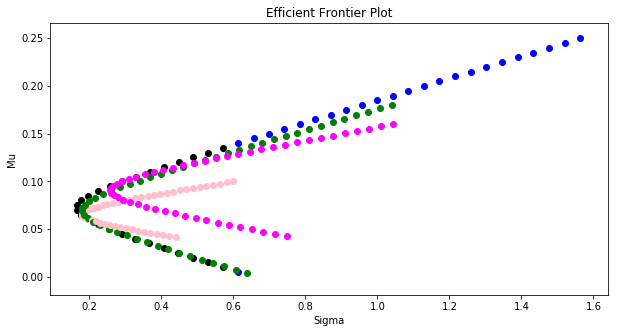

In [6]:
mu = np.array([0.06, 0.08, 0.12])
CC = np.array([[0.04, 0.01, -0.01], [0.01, 0.09, 0], [-0.01, 0, 0.25]])

plt.figure(figsize=(10, 5))
plt.title('Efficient Frontier Plot')
plt.ylabel('Mu')
plt.xlabel('Sigma')

uVec = np.transpose(np.array([1, 1, 1]))
wMin = minVarW(uVec, CC)
print('5a) The portfolio weights that minimize total portfolio variance is \n\t%s.'%(wMin,))

for i in range(1, 51):
    w = effPort(i/200, mu, CC)/sum(effPort(i/200, mu, CC))
    if 0 < sigmaX(w, CC) < 0.6:
        plotW(w, CC, mu, c = 'black', label = 'efficient:black') # efficient
    else:
        plotW(w, CC, mu, c = 'blue', label = 'inefficient:blue')

# 5b 
m12 = np.array([0.06, 0.08])
m13 = np.array([0.06, 0.12])
m23 = np.array([0.08, 0.12])

c12 = np.array([[0.04, 0.01], [0.01, 0.09]])
c13 = np.array([[0.04, -0.01], [-0.01, 0.25]])
c23 = np.array([[0.09, 0], [0, 0.25]])

uVec2 = np.transpose(np.array([1, 1]))
w12 = minVarW(uVec2, c12); mu12 = muX(w12, m12); sig12 = sigmaX(w12, c12)
w13 = minVarW(uVec2, c13); mu13 = muX(w13, m13); sig13 = sigmaX(w13, c13)
w23 = minVarW(uVec2, c23); mu23 = muX(w23, m23); sig23 = sigmaX(w23, c23)
print('\n5b)\n\tThe min-Var portfolio weights with Assets 1&2 is \n\t%s and its expected'%(w12,))
print('\treturn is %s and standard deviation is %s.'%(mu12, sig12))
print('\n\tThe min-Var portfolio weights with Assets 1&3 is \n\t%s and its expected'%(w13,))
print('\treturn is %s and standard deviation is %s.'%(mu13, sig13))
print('\n\tThe min-Var portfolio weights with Assets 2&3 is \n\t%s and its expected'%(w23,))
print('\treturn is %s and standard deviation is %s.'%(mu23, sig23))

for i in np.arange(-1, 2, 0.06):
    plotW(np.array([i, 1-i]), c12, m12, c = 'pink', label = 'asset1&2:pink')
    plotW(np.array([i, 1-i]), c13, m13, c = 'green', label = 'asset1&3:green')
    plotW(np.array([i, 1-i]), c23, m23, c = 'magenta', label = 'asset2&3:magenta')    
    
print("\n5c) Legend: \n \tefficient:black \n \tinefficient:blue \n \tasset1&2:pink \n \tasset1&3:green \n \tasset2&3:magenta")

5c) These four curves and four minimum variance portfolios look relative to each other because they all share approximately the same expected returns per stock and covariance matrix.

__Problem 6__ For 276 students: Use the setting of Problem 5. Suppose I want to buy a portfolio
with $\overrightarrow{w} = [0.1,\; 0.2,\; 0.7]$. Explain why this is not efficient and offer me AT LEAST 2 strictly better alternatives. Specifically, find the portfolio which maximizes return while keeping same risk as mine, and the one that minimizes risk while keeping the same return as mine.

In [7]:
mu = np.array([0.06, 0.08, 0.12])
CC = np.array([[0.04, 0.01, -0.01], [0.01, 0.09, 0], [-0.01, 0, 0.25]])

print('The portfolio with w = [0.1, 0.2, 0.7] gives an expected return of', 
      muX(np.array([0.1, 0.2, 0.7]), mu), 
      '\nand a standard deviation of %s.'%sigmaX(np.array([0.1, 0.2, 0.7]), CC))

effW = effPort(muX(np.array([0.1, 0.2, 0.7]), mu), mu, CC)
sd = sigmaX(effW, CC)
print('\nThis is inefficient because the following weights:%s'%(effW,),
      '\nalso give the same expected return, but with a risk/stddev of %s.'%sd)

The portfolio with w = [0.1, 0.2, 0.7] gives an expected return of 0.10599999999999998 
and a standard deviation of 0.35425979167836696.

This is inefficient because the following weights:[-0.11698113  0.5254717   0.59150943] 
also give the same expected return, but with a risk/stddev of 0.33618980488060624.


Additionally, if we want to maximize return but keeping the same risk as the portfolio with $\overrightarrow{w} = [0.1,\; 0.2,\; 0.7]$, then we should use the following weights below.

In [8]:
risk = sigmaX(np.array([0.1, 0.2, 0.7]), CC)
table = pd.DataFrame({'w': [effPort(i/7000, mu, CC)/sum(effPort(i/7000, mu, CC)) 
                            for i in range(1, 1001)]})
table['mu_V'] = np.array([muX(table['w'][i], mu) 
                          for i in range(len(table['w']))])
table['sigma_V'] = np.array([sigmaX(table['w'][i], CC)
                          for i in range(len(table['w']))])

idx = table.loc[table['sigma_V'] <= risk, ['mu_V']].idxmax()
table.iloc[idx]
print(table.iloc[idx, 0].iloc[0])
print('These following weights give the expected return of %s\n with a risk of %s.'
     %(table.iloc[idx, 1].iloc[0], table.iloc[idx, 2].iloc[0]))

[-0.16873315  0.54595687  0.62277628]
These following weights give the expected return of 0.10828571428571426
 with a risk of 0.3538175380217644.
